# Feature Meanings and Predication for Used Car Auction Prices 

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,accuracy_score
from sklearn.ensemble import RandomForestRegressor
import optuna
import lightgbm as lgb  

In [2]:
df = pd.read_csv('datasets/project_car_prices.csv',error_bad_lines=False,warn_bad_lines=True)

b'Skipping line 408163: expected 16 fields, saw 17\nSkipping line 417837: expected 16 fields, saw 17\nSkipping line 421291: expected 16 fields, saw 17\nSkipping line 424163: expected 16 fields, saw 17\n'
b'Skipping line 427042: expected 16 fields, saw 17\nSkipping line 427045: expected 16 fields, saw 17\nSkipping line 434426: expected 16 fields, saw 17\nSkipping line 444503: expected 16 fields, saw 17\nSkipping line 453796: expected 16 fields, saw 17\n'
b'Skipping line 461599: expected 16 fields, saw 17\nSkipping line 461614: expected 16 fields, saw 17\n'
b'Skipping line 492486: expected 16 fields, saw 17\nSkipping line 497010: expected 16 fields, saw 17\nSkipping line 497013: expected 16 fields, saw 17\nSkipping line 499085: expected 16 fields, saw 17\nSkipping line 501457: expected 16 fields, saw 17\nSkipping line 505301: expected 16 fields, saw 17\nSkipping line 505308: expected 16 fields, saw 17\nSkipping line 520463: expected 16 fields, saw 17\n'
b'Skipping line 528998: expected 1

In [3]:
df.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


## Meaning of Special Features

Most of the features are easy to understand, but there are some special.

### vin: Vehicle identification number

The first special feature is `vin`. From `wikipedia`, `vin` means ***Vehicle identification number***.
> A vehicle identification number (VIN) (also called a chassis number or frame number) is a unique code, including a serial number, used by the automotive industry to identify individual motor vehicles, towed vehicles, motorcycles, scooters and mopeds, as defined in ISO 3779 (content and structure) and ISO 4030 (location and attachment).

>  A `vin` has 17 letters. Components of `vin` are `World manufacturer identifier`(1-3),`Vehicle descriptor section`(4-9) and	`Vehicle identifier section`(10-17).

> Country or region codes can be distinguished by the first 2 letters of `World manufacturer identifier`.

> https://en.wikipedia.org/wiki/Vehicle_identification_number#Components

So we can **add a feature `made_country` with the first 2 letters of `vin`**.


We can check the info of a vin by https://driving-tests.org/vin-decoder/. If we query the first vin of the data `5xyktca69fg566472`,we can get a result like :

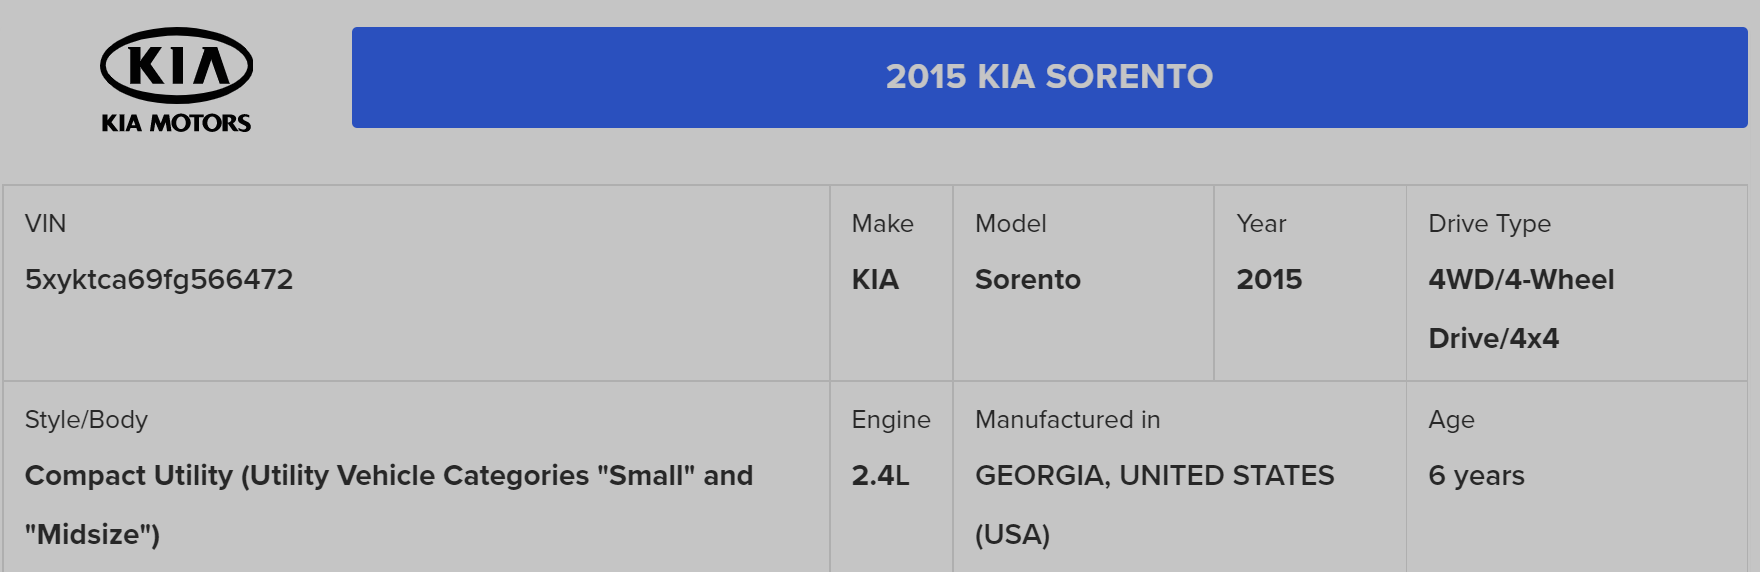

In [4]:
df['made_country']=df['vin'].map(lambda x:x[:2])

### mmr: Manheim Market Report

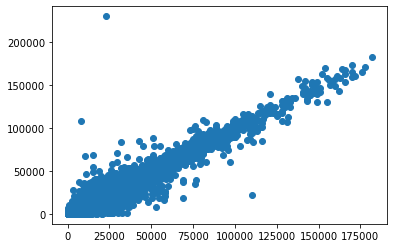

In [5]:
plt.scatter(df['mmr'],df['sellingprice'])
plt.show()

What really intersting is that `mmr` and `sellingprice` are so highly correlated. I did not find an explanation in `wikipedia`. But with Google I found this https://www.autoauctionmall.com/learning-center/what-does-mmr-mean/. 
> MMR in the car business stands for Manheim Market Report, an indicator of wholesale prices.

> Manheim is a company established in 1945 as a car auction company. It has grown to a very reputable company and its MMR is a baseline tool for wholesale car price determination. They base their price calculations on over 10 million transaction over the past 13-month period to .

I think that explained  why `mmr` and `sellingprice` are so close to each other in the figure. `mmr` is a valuation made by the Manheim company.The company should make full use of all the infomation of car like `model`,`odometer` and so on.

So it is **not** a good idea to take `mmr` as a explanatory feature.

### odometer: measuring the distance traveled by a vehicle

In [6]:
df['odometer'].mean()

68323.19579679874

<AxesSubplot:ylabel='Frequency'>

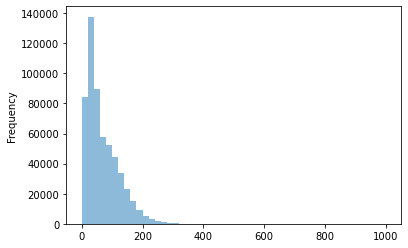

In [7]:
(df['odometer']/1000).plot.hist(bins=50, alpha=0.5)

`odometer` means:
> An odometer or odograph is an instrument used for measuring the distance traveled by a vehicle, such as a bicycle or car. The device may be electronic, mechanical, or a combination of the two (electromechanical). The noun derives from ancient Greek ὁδόμετρον, hodómetron, from ὁδός, hodós ("path" or "gateway") and μέτρον, métron ("measure"). Early forms of the odometer existed in the ancient Greco-Roman world as well as in ancient China. In countries using Imperial units or US customary units it is sometimes called a mileometer or milometer, the former name especially being prevalent in the United Kingdom and among members of the Commonwealth.
> https://en.wikipedia.org/wiki/Odometer

From the figure above,the unit of measurement may be `kilometers`. If that is true, the mean odometer of used cars is 68000 kilometers. And most of them are within 200000 kilometers.

### year: vehicle's model year

After checking several vins, the `year` equals vehicle's model year.

In [8]:
# change `mmr` to `valuation` and `year` to `model_year` for better understand
df=df.rename(columns={'mmr':'valuation','year':'model_year'})

##  Data Preparation

 overview of the data


In [9]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['null_per'],axis=1,ascending=False)

,transmission,body,condition,trim,model,make,color,interior,odometer,valuation,saledate,sellingprice,model_year,seller,state,vin,made_country
null_per,0.11695,0.023613,0.021106,0.01906,0.018609,0.018434,0.00134,0.00134,0.000168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,object,object,float64,object,object,object,object,object,float64,int64,object,int64,int64,object,object,object,object
nuique,2,86,41,1975,973,96,20,17,172277,1101,3745,1887,34,14264,38,550296,103


handle missing values, drop them all since the the ratio is not high.


In [10]:
df=df.dropna(axis=0)

data extract


In [11]:
# extract `made_country` from vin
df['made_country']=df['vin'].map(lambda x:x[:2])

In [12]:
# extract selling date info
df['sale_datetime'] = pd.to_datetime(df['saledate'],utc=True)


In [13]:
df['sale_year']=df['sale_datetime'].dt.year.astype('int8')
df['sale_quarter']=df['sale_datetime'].dt.quarter.astype('int8')
df['sale_month']=df['sale_datetime'].dt.month.astype('int8')
df['sale_dayofweek']=df['sale_datetime'].dt.day_of_week.astype('int8')
df['sale_day']=df['sale_datetime'].dt.day.astype('int8')
df['sale_hour']= df['sale_datetime'].dt.hour.astype('int8')

In [14]:
# clean body
df['xbody']=df['body'].map(lambda x:str(x).lower())

In [15]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['null_per'],axis=1,ascending=False)

,model_year,valuation,sale_hour,sale_day,sale_dayofweek,sale_month,sale_quarter,sale_year,sale_datetime,made_country,...,color,odometer,condition,state,vin,transmission,body,trim,model,xbody
null_per,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,int64,int64,int8,int8,int8,int8,int8,int8,"datetime64[ns, UTC]",object,...,object,float64,float64,object,object,object,object,object,object,object
nuique,26,1099,21,31,6,8,4,2,3609,101,...,20,160427,41,34,465779,2,85,1507,768,45


In [16]:
# compress data
df['mode_year']= df['model_year'].astype('int8')

## How do we access the value of a car without valuations by specilists?

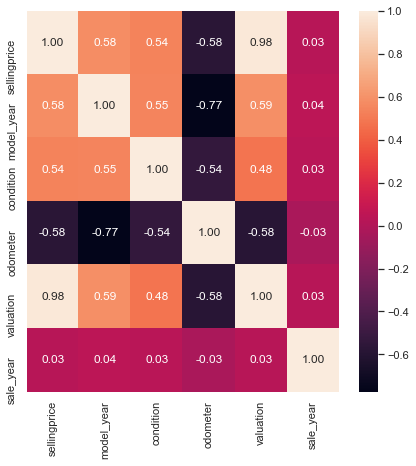

In [17]:
heatmap_col=['sellingprice','model_year','condition','odometer','valuation','sale_year']
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(df[heatmap_col].corr(), annot=True, fmt=".2f");

In [18]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['nuique'],axis=1,ascending=True).T

,null_per,dtypes,nuique
transmission,0.0,object,2
sale_year,0.0,int8,2
sale_quarter,0.0,int8,4
sale_dayofweek,0.0,int8,6
sale_month,0.0,int8,8
interior,0.0,object,17
color,0.0,object,20
sale_hour,0.0,int8,21
model_year,0.0,int64,26
mode_year,0.0,int8,26


In [19]:
# choose features and filter `valuation` out
choosed_cols = ['model_year','condition','odometer','sellingprice',
                'make','model','trim','transmission','state','color','interior',
                'sale_dayofweek','sale_month','made_country','xbody']

In [20]:
ff=df[choosed_cols].copy()

In [21]:
# One-Hot Encode 
cat_cols = ff.select_dtypes(include=['object']).columns
ff_1 = pd.get_dummies(ff[cat_cols],dummy_na=False,prefix_sep='_',drop_first=True)
ff_2 = ff.drop(cat_cols,axis=1)

gf = ff_1.merge(ff_2,left_index=True,right_index=True)

In [22]:
X_df = gf.drop(['sellingprice'],axis=1)
y_df = gf['sellingprice']


In [23]:
def objective(trial):
    data,target = X_df.values,y_df.values
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    param = {
        "n_estimators":trial.suggest_int("n_estimators",20,200,log=True),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    score = r2_score(valid_y, pred_labels)
    return score


In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-08-18 10:41:52,280] A new study created in memory with name: no-name-629682ca-ac5a-415b-a649-1ec318528b08
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3277
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1474
[LightGBM] [Info] Start training from score 13701.071249


[I 2021-08-18 10:43:49,068] Trial 0 finished with value: 0.850686887691557 and parameters: {'n_estimators': 42}. Best is trial 0 with value: 0.850686887691557.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3275
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1473
[LightGBM] [Info] Start training from score 13686.553835


[I 2021-08-18 10:45:23,941] Trial 1 finished with value: 0.7786843586479512 and parameters: {'n_estimators': 23}. Best is trial 0 with value: 0.850686887691557.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3255
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1463
[LightGBM] [Info] Start training from score 13688.454027


[I 2021-08-18 10:47:00,147] Trial 2 finished with value: 0.9231526326029289 and parameters: {'n_estimators': 124}. Best is trial 2 with value: 0.9231526326029289.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3283
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1477
[LightGBM] [Info] Start training from score 13687.090136


[I 2021-08-18 10:48:36,871] Trial 3 finished with value: 0.9284901286592577 and parameters: {'n_estimators': 186}. Best is trial 3 with value: 0.9284901286592577.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3267
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1469
[LightGBM] [Info] Start training from score 13700.433841


[I 2021-08-18 10:50:13,781] Trial 4 finished with value: 0.8894483989120062 and parameters: {'n_estimators': 72}. Best is trial 3 with value: 0.9284901286592577.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3279
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1475
[LightGBM] [Info] Start training from score 13683.084736


[I 2021-08-18 10:51:50,885] Trial 5 finished with value: 0.9109601981134319 and parameters: {'n_estimators': 91}. Best is trial 3 with value: 0.9284901286592577.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3289
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1480
[LightGBM] [Info] Start training from score 13686.416822


[I 2021-08-18 10:53:07,260] Trial 6 finished with value: 0.7872567816037058 and parameters: {'n_estimators': 24}. Best is trial 3 with value: 0.9284901286592577.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3277
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1474
[LightGBM] [Info] Start training from score 13687.884142


[I 2021-08-18 10:54:31,890] Trial 7 finished with value: 0.8949321321053733 and parameters: {'n_estimators': 69}. Best is trial 3 with value: 0.9284901286592577.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3291
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1481
[LightGBM] [Info] Start training from score 13692.837472


[I 2021-08-18 10:55:53,171] Trial 8 finished with value: 0.9360829514734793 and parameters: {'n_estimators': 180}. Best is trial 8 with value: 0.9360829514734793.
D:\proProgrammes\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the train set: 354252, number of used features: 1472
[LightGBM] [Info] Start training from score 13690.449028


[I 2021-08-18 10:57:17,945] Trial 9 finished with value: 0.8822771307083674 and parameters: {'n_estimators': 59}. Best is trial 8 with value: 0.9360829514734793.


Number of finished trials: 10
Best trial:
  Value: 0.9360829514734793
  Params: 
    n_estimators: 180


In [25]:
# one of the best params the optuna computed is 198
train_x, valid_x, train_y, valid_y = train_test_split(X_df.values, y_df.values,
                                                      test_size=0.25,random_state=100)
lgb_clf = lgb.LGBMRegressor(n_estimators=198)
lgb_clf.fit(train_x,train_y)
print(lgb_clf.score(valid_x,valid_y))


0.9379841747670348


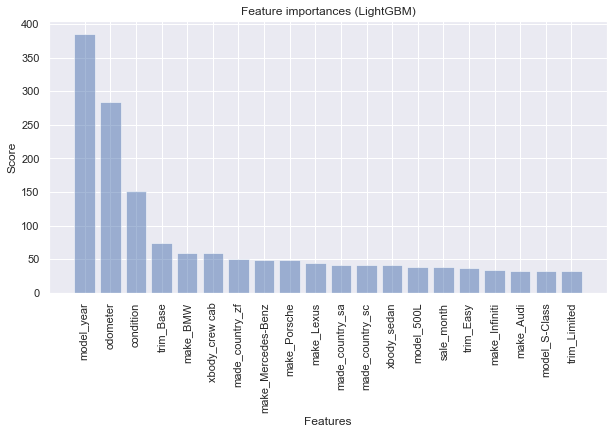

In [26]:
#inspiration by https://www.kaggle.com/aleksandradeis/airbnb-seattle-reservation-prices-analysis#Machine-Learning
headers = ["name", "score"]
values = sorted(zip(X_df, lgb_clf.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:20]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:20]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (LightGBM)') 
plt.show()

## Conclusion

In this analysis we tried to understand what influences used car 's selling price. We delete `valuation` from explained features, since it is a evaluated feature by business company. Alternatively, we tried to use basic info of a car to do a predict. The model has a similar `r2_score` with `valuation` and suggested `model_year`,`odometer`,`condition`  are the 3 features contributes most to the model.

Hope the predication is helpful to people who want to sell their cars!